# $\textit{Detección de ondas gravitatorias}$
$\textit{Estimación Espectral No Paramétrica}$

In [1]:
#En ppio hay que elegir entre 32sec • 4KHz o 4096sec • 4KHz. Esto porque el evento esta alrededor de los 2Khz.
#Ademas, usamos el dataset de 4096 seg porque el ruido es localmente estacionario (hay que probarlo).



In [30]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
sns.set_theme()

In [3]:
# these 4096 second files are useful for computing more accurate psds
largeFilenamePart = {'GW150914': 'GWOSC_4KHZ_R1-1126257415-4096.hdf5'}
fn_H1 = './Data/H-H1_' + largeFilenamePart['GW150914']
fn_L1 = './Data/L-L1_' + largeFilenamePart['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

Using sample rate of 4096 Hz found in file: ./Data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [4]:
import readligo as rl
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

In [5]:
len(strain_H1)

16777216

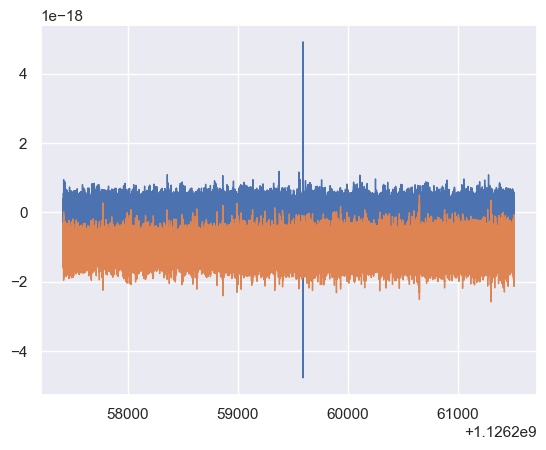

In [34]:
plt.plot(time_H1, strain_H1, linewidth=1)
plt.plot(time_L1, strain_L1, linewidth=1)

In [7]:
time = time_H1
indxt_around = np.where((time >= time_center - 512) & (time < time_center + 512))

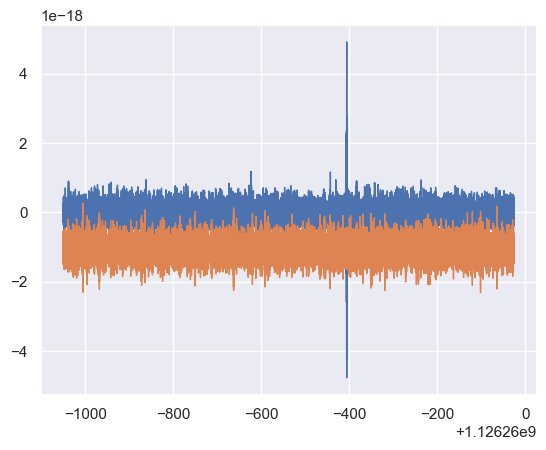

In [35]:
plt.plot(time_H1[indxt_around], strain_H1[indxt_around], linewidth=1)
plt.plot(time_L1[indxt_around], strain_L1[indxt_around], linewidth=1)

# $\textit{Elegimos la ventana}$

In [60]:
from numpy.fft import fft
from numpy.fft import fftshift

In [149]:
N = 2**6
n = np.linspace(0,N-1,N)

HanW = 0.5 - 0.5 * np.cos((2*np.pi*n)/(N-1)) #Hanning window
HamW = 0.54 - 0.46 * np.cos((2*np.pi*n)/(N-1)) #Hamming window

currWindow = HamW #Choose window

(-120.0, 1.0)

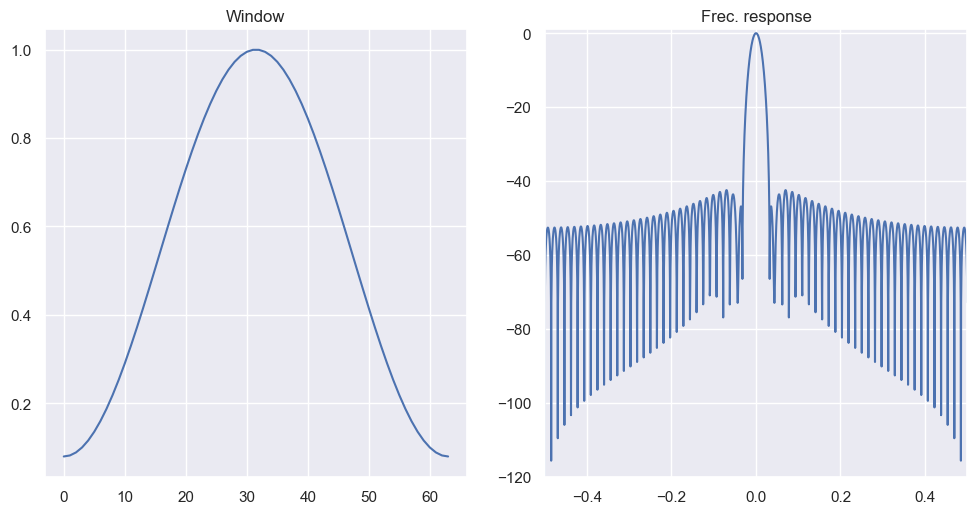

In [156]:
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0)
fig.set_figwidth(10)

A = fft(currWindow, 2048) / (N/2.0)
mag = np.abs(fftshift(A))
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))

axs[0].set_title("Window")
axs[0].plot(currWindow)

axs[1].set_title("Frec. response")
axs[1].plot(freq, response)
axs[1].set_xlim([-0.5, 0.5])
axs[1].set_ylim([-120, 1])

# $\textit{Agarramos ventanas de datos de tamaño L}$

In [157]:
after = np.max(indxt_around)
before = np.min(indxt_around)

#Getting an neighbourhood of the event
strain_H1_after_noise = strain_H1[:after]
strain_L1_after_noise = strain_L1[:after]
strain_H1_before_noise = strain_H1[before:]
strain_L1_before_noise = strain_L1[before:]

for 

In [159]:
T = 2**23
T

8388608

# $\textit{Calculamos la PSD}$

In [160]:
def estimateAutocorrelation(seq):
    
    N = len(seq)
    rx = np.zeros(N)
    
    for l in range(N):
        acc = 0
        for n in range(N-l):
            acc += (seq[n+l]) * np.conjugate(seq[n])
        rx[l] = acc / N
    
    return rx


In [164]:
def PSD(seq):
    rv = estimateAutocorrelation(seq)
    Rx = np.abs(fftshift(fft(rv,2048)))
    return Rx

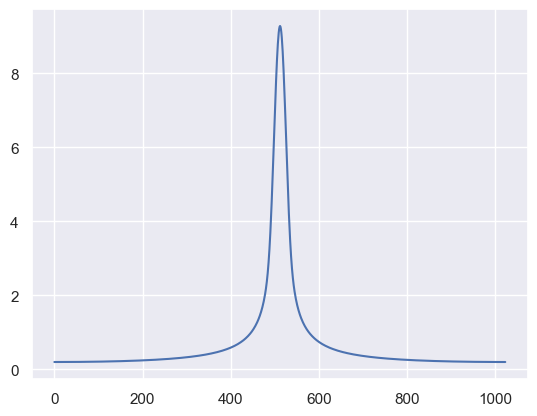

In [165]:
plt.plot(PSD(currWindow))